# Supplement - Sensitivity Analysis
This notebook generates Figure 3 and 4 in the supplementary material. This figure shows the sensitivity of key outputs as a function of the outlet pressure drop, $p_4-p_1$, and the wake spreading parameter, $\beta$. Outlet streamwise velocity is particularly sensitive to changes in these values, and it's sensitivity is plotted in Figure 3. Likewise, the outlet pressure drop is sensitive to the parameter $\beta$, which is plotted in Figure 4.

## Note
To run this notebook, extra `autodiff` feature is required. This extra contains the `Dualitic` autodifferentiator which is used to determine the sensitivity to $\beta$ and $p_4-p_1$. The `autodiff` extra feature can be installed using:
```
pip install git+https://github.com/Howland-Lab/Unified-Momentum-Model.git[autodiff]
```

## Generate data using model
The pressure-corrected actuator disk model is run over a grid of $C_T'$ and yaw angles, $\gamma$. Autodifferentiation is performed to retrieve all gradients with respesct to $\beta$. This is achieved by replacing $\beta$ with a dual number.

In [1]:
from UnifiedMomentumModel.Pressure.PressureTable import generate_pressure_table


dps, xs, ps = generate_pressure_table()

In [2]:
try:
    import dualitic as dl
except ModuleNotFoundError as e:
    print(
        "dualitic module not found. Please reinstall the UnifiedMomentumModel package with the `autodiff` extra feature."
    )
    raise e

from pathlib import Path
import itertools
import os

import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import polars as pl
from scipy.interpolate import RectBivariateSpline

from foreach import foreach
from UnifiedMomentumModel.Utilities.FixedPointIteration import (
    _fixedpointiteration,
    fixedpointiteration,
)
from UnifiedMomentumModel.Momentum import UnifiedMomentum

# Use Latex Fonts
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})


figdir = Path(os.getcwd()).parent / "fig"
figdir.mkdir(exist_ok=True, parents=True)
figdir_eps = figdir / "eps"
figdir_eps.mkdir(exist_ok=True, parents=True)

## Pressure, $\Delta P$, Sensitivity
This notebook investigates the sensitivity of the pressure-corrected actuator disk model with respect to the pressure, $\Delta P$. 

## Modify model equations to set pressure explicitly

In [3]:
def equations_residual(x, Ctprime, gamma, dp=0.0, TI=0.0, alpha=0.58, beta=0.1403):
    an, u4, v4 = x

    e_an = (
        1
        - np.sqrt(
            -dp / (0.5 * Ctprime * np.cos(gamma) ** 2)
            + (1 - u4**2 - v4**2) / (Ctprime * np.cos(gamma) ** 2)
        )
        - an
    )

    e_u4 = (
        -(1 / 4) * Ctprime * (1 - an) * np.cos(gamma) ** 2
        + (1 / 2)
        + (1 / 2)
        * np.sqrt((1 / 2 * Ctprime * (1 - an) * np.cos(gamma) ** 2 - 1) ** 2 - (4 * dp))
    ) - u4

    e_v4 = -(1 / 4) * Ctprime * (1 - an) ** 2 * np.sin(gamma) * np.cos(gamma) ** 2 - v4
    if np.isnan(e_an):
        # breakpoint()
        pass
    return e_an, e_u4, e_v4


def solve_modified(Ctprime, yaw, x0, **kwargs):
    sol = _fixedpointiteration(
        equations_residual,
        x0,
        relax=0.5,
        args=(Ctprime, yaw),
        kwargs=kwargs,
    )

    if sol.converged:
        return sol.x
    else:
        return np.nan, np.nan, np.nan

### Generate data using model
The pressure-corrected actuator disk model is run over a grid of $C_T'$ and yaw angles, $\gamma$. Autodifferentiation is performed to retrieve all gradients with respesct to $p_4-p_1$. This is achieved by replacing $ $p_4-p_1$$ with a dual number in a modified unified momentum implementation where the pressure can be set explicitly.

In [4]:
Cts = np.arange(0.2, 12.1, 0.2)
yaws = np.arange(0, 61, 5)

params = list(itertools.product(Cts, yaws))


params = list(itertools.product(Cts, yaws))
unified_momentum_model = UnifiedMomentum()


def func(x):
    Ctprime, yaw = x

    # Solve the full equations to get the actual pressure difference.
    sol = unified_momentum_model(Ctprime, np.deg2rad(yaw))
    _a, _u4, _v4, dp = sol.an, sol.u4, sol.v4, sol.dp
    dp = dl.DualNumber(dp, [1.0])
    x0 = (_a * 0.9, _u4 * 0.9, _v4 * 0.9)

    a, u4, v4 = solve_modified(Ctprime, np.deg2rad(yaw), x0, dp=dp)
    Ct = Ctprime * (1 - a) ** 2 * np.cos(np.deg2rad(yaw)) ** 2
    Cp = Ctprime * ((1 - a) * np.cos(np.deg2rad(yaw))) ** 3

    if not isinstance(a, dl.DualNumber):
        out = dict(
            Ctprime=Ctprime,
            Ct=np.nan,
            yaw=yaw,
            a=np.nan,
            u4=np.nan,
            v4=np.nan,
            dp=np.nan,
            Cp=np.nan,
        )
        return out, out

    return dict(
        Ctprime=Ctprime,
        Ct=Ct.real[0],
        yaw=yaw,
        a=a.real[0],
        u4=u4.real[0],
        v4=v4.real[0],
        dp=dp.real[0],
        Cp=Cp.real[0],
    ), dict(
        Ctprime=Ctprime,
        Ct=Ct.dual[0][0],
        yaw=yaw,
        a=a.dual[0][0],
        u4=u4.dual[0][0],
        v4=v4.dual[0][0],
        dp=dp.dual[0][0],
        Cp=Cp.dual[0][0],
    )


np.seterr(invalid="ignore")
out = foreach(func, params, parallel=True)
df_pressure_real = pl.from_dicts([x[0] for x in out])
df_pressure_dual = pl.from_dicts([x[1] for x in out])

100%|██████████| 780/780 [00:01<00:00, 560.04it/s]


## Table

In [5]:
values_real = (
    df_pressure_real.filter(pl.col("Ctprime") == 2)
    .filter(pl.col("yaw") == 0)
    .select(pl.exclude("Ctprime", "yaw", "v4", "Ct"), "Ct")
)
values_dual = (
    df_pressure_dual.filter(pl.col("Ctprime") == 2)
    .filter(pl.col("yaw") == 0)
    .select(pl.exclude("Ctprime", "yaw", "v4", "Ct"), "Ct")
)

(values_dual * values_real["dp"] / values_real)

a,u4,dp,Cp,Ct
f64,f64,f64,f64,f64
-0.010108,0.129042,1.0,0.01503,0.01002


## $\beta$ Sensitivity
This notebook investigates the sensitivity of the pressure-corrected actuator disk model with respect to th parameter, $\beta$, which is related to the near-wake distance.

In [6]:
class RectBivariateSpline_override:
    def __init__(self, x, y, z, *args, **kwargs):
        self.spline = RectBivariateSpline(x, y, z, *args, **kwargs)

    def __call__(self, x, y, dx=0, dy=0, grid=True):
        if isinstance(x, dl.DualNumber) and isinstance(y, dl.DualNumber):
            if grid == True:
                raise NotImplementedError
            primal = self.spline(x.real, y.real, dx=dx, dy=dy, grid=grid)
            dual = (
                x.dual
                * self.spline(x.real, y.real, dx=dx + 1, dy=dy, grid=grid)[..., None]
                + y.dual
                * self.spline(x.real, y.real, dx=dx, dy=dy + 1, grid=grid)[..., None]
            )
            return dl.DualNumber(primal, dual)
        elif (not isinstance(x, dl.DualNumber)) and isinstance(y, dl.DualNumber):
            if grid == True:
                raise NotImplementedError
            primal = self.spline(x, y.real, dx=dx, dy=dy, grid=grid)
            dual = (
                y.dual * self.spline(x, y.real, dx=dx, dy=dy + 1, grid=grid)[..., None]
            )
            return dl.DualNumber(primal, dual)
        else:
            return self.spline(x, y, dx=dx, dy=dy, grid=grid)

    def get_coeffs(self):
        return self.spline.get_coeffs()

    def get_knots(self):
        return self.spline.get_knots()

    def get_residual(self):
        return self.spline.get_residual()

    def integral(self):
        raise NotImplementedError

    def partial_derivative(self, dx, dy):
        raise NotImplementedError


interpolator = RectBivariateSpline_override(dps, xs, ps, kx=2, ky=2, s=0.0)

In [7]:
def my_dual_number_nonlinear_interpolator(x):
    dp, x0 = x

    p_g = interpolator(dp, x0, grid=False)
    return p_g

In [8]:
beta = dl.DualNumber([0.1403], [[1]])

unified_momentum_model = fixedpointiteration(max_iter=1000, tolerance=0.000001)(
    UnifiedMomentum
)(beta=beta)
unified_momentum_model.nonlinear_interpolator = my_dual_number_nonlinear_interpolator


def func(x):
    Ctprime, yaw = x
    solution = unified_momentum_model(Ctprime, np.deg2rad(yaw))

    return dict(
        Ctprime=Ctprime,
        Ct=solution.Ct.real[0],
        yaw=yaw,
        a=solution.an.real[0],
        u4=solution.u4.real[0],
        v4=solution.v4.real[0],
        dp=solution.dp.real[0],
        Cp=solution.Cp.real[0],
    ), dict(
        Ctprime=Ctprime,
        Ct=solution.Ct.dual[0][0],
        yaw=yaw,
        a=solution.an.dual[0][0],
        u4=solution.u4.dual[0][0],
        v4=solution.v4.dual[0][0],
        dp=solution.dp.dual[0][0],
        Cp=solution.Cp.dual[0][0],
    )


np.seterr(invalid="ignore")
out = foreach(func, params, parallel=True)
df_beta_real = pl.from_dicts([x[0] for x in out])
df_beta_dual = pl.from_dicts([x[1] for x in out])

100%|██████████| 780/780 [00:06<00:00, 114.97it/s]


# Save data to file

In [15]:
SOURCEDATADIR = Path(os.getcwd()).parent / "source_data/Figure_supp_04_05"
SOURCEDATADIR.mkdir(exist_ok=True, parents=True)

df_out = pl.concat([
    df_pressure_real.with_columns(pl.lit("pressure_primal").alias("description")),
    df_pressure_dual.with_columns(pl.lit("pressure_dual").alias("description")),
    df_beta_real.with_columns(pl.lit("beta_rea").alias("description")),
    df_beta_dual.with_columns(pl.lit("beta_dual").alias("description")),
])
df_out.write_csv(SOURCEDATADIR / "Figure_supp_04_05_primal_dual.csv")

## Table

In [10]:
values_real = (
    df_beta_real.filter(pl.col("Ctprime") == 2)
    .filter(pl.col("yaw") == 0)
    .select(pl.exclude("Ctprime", "yaw", "v4", "Ct"), "Ct")
)
values_real
values_dual = (
    df_beta_dual.filter(pl.col("Ctprime") == 2)
    .filter(pl.col("yaw") == 0)
    .select(pl.exclude("Ctprime", "yaw", "v4", "Ct"), "Ct")
)

(values_dual * beta.real[0] / values_real)

a,u4,dp,Cp,Ct
f64,f64,f64,f64,f64
-0.010347,0.133697,1.042294,0.015389,0.010259


# Plotting
Various values as well as their gradient field (with respect to $\beta$) are plotted as contour plots as a function of $C_T'$ and $\gamma$. All figures set $\Delta \beta=0.01$.

In [11]:
results = []

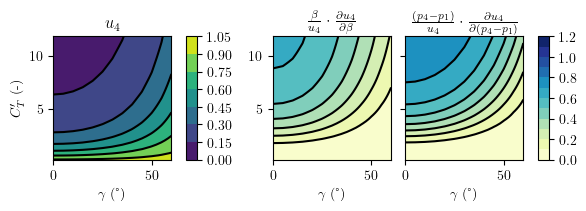

In [12]:
# plot versus Ctprime

figdir_surface = figdir / "beta_sensitivity"
figdir_surface.mkdir(parents=True, exist_ok=True)


key, label = "u4", "u_4"
# plot versus Ctprime
fig = plt.figure(figsize=0.8 * np.array((8, 2)))
gs = GridSpec(1, 6, width_ratios=[1, 0.1, 0.4, 1, 1, 0.1])

axes = [plt.subplot(gs[0])]
axes.append(plt.subplot(gs[3], sharey=axes[0]))
axes.append(plt.subplot(gs[4], sharey=axes[0]))
plt.setp(axes[2].get_yticklabels(), visible=False)

axes[0].set_title(f"${label}$")
label_sensitivity = (
    "$\\frac{\\beta}{"
    + label
    + "}\cdot \\frac{\partial "
    + label
    + "}{\partial \\beta}$"
)
axes[1].set_title(label_sensitivity, pad=8)
label_sensitivity = (
    "$\\frac{(p_4-p_1)}{"
    + label
    + "}\cdot \\frac{\partial "
    + label
    + "}{\partial (p_4-p_1)}$"
)
axes[2].set_title(label_sensitivity, pad=8)

df_piv_real = df_pressure_real.filter(pl.col("Ctprime") < 12).pivot(
    index="Ctprime", columns="yaw", values=key
)

df_pressure_piv_dual = df_pressure_dual.filter(pl.col("Ctprime") < 12).pivot(
    index="Ctprime", columns="yaw", values=key
)

df_beta_piv_dual = df_beta_dual.filter(pl.col("Ctprime") < 12).pivot(
    index="Ctprime", columns="yaw", values=key
)

df_piv_pressure = df_pressure_real.filter(pl.col("Ctprime") < 12).pivot(
    index="Ctprime", columns="yaw", values="dp"
)
yaws = np.array(df_piv_real.columns[1:], dtype=float)

Cts = df_piv_real["Ctprime"].to_numpy()
values_real = df_piv_real.to_numpy()[:, 1:]
values_beta_dual = df_beta_piv_dual.to_numpy()[:, 1:]
values_pressure_dual = df_pressure_piv_dual.to_numpy()[:, 1:]
values_pressure = df_piv_pressure.to_numpy()[:, 1:]

level = None

CF = axes[0].contourf(yaws, Cts, values_real, levels=level)
CS = axes[0].contour(yaws, Cts, values_real, levels=level, colors="k")

cax = plt.subplot(gs[1])
cbar = plt.colorbar(CF, cax=cax, format="%.2f")


sensitivity_levels = [x for x in np.arange(0, 1.3, 0.1)]
CF = axes[1].contourf(
    yaws,
    Cts,
    beta.real[0] * values_beta_dual / values_real,
    levels=sensitivity_levels,
    cmap="YlGnBu",
)
CS = axes[1].contour(
    yaws,
    Cts,
    beta.real[0] * values_beta_dual / values_real,
    levels=sensitivity_levels,
    colors="k",
)

axes[2].contourf(
    yaws,
    Cts,
    values_pressure * values_pressure_dual / values_real,
    levels=sensitivity_levels,
    cmap="YlGnBu",
)
CS = axes[2].contour(
    yaws,
    Cts,
    values_pressure * values_pressure_dual / values_real,
    levels=sensitivity_levels,
    colors="k",
)

cax = plt.subplot(gs[5])
cbar = plt.colorbar(CF, cax=cax)

axes[2].set_xlabel("$\gamma$ (°)")
axes[1].set_xlabel("$\gamma$ (°)")
axes[0].set_xlabel("$\gamma$ (°)")
axes[0].set_ylabel("$C_T'$ (-)")

plt.savefig(figdir / f"supplement_u4_sensitivity.png", dpi=300, bbox_inches="tight")
plt.savefig(figdir_eps / f"supplement_u4_sensitivity.eps", bbox_inches="tight")

In [13]:
def xy_to_ij(x: ArrayLike, y: ArrayLike) -> tuple[ArrayLike, ArrayLike]:
    """
    Converts meshgrid output of two input vectors from xy indexing to ij
    indexing.
    """
    return x.T, y.T

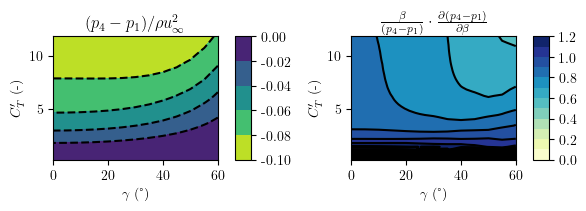

In [14]:
# plot versus Ctprime
fig = plt.figure(figsize=0.8 * np.array((8, 2)))
gs = GridSpec(1, 5, width_ratios=[1, 0.1, 0.4, 1, 0.1])

axes = [plt.subplot(gs[0])]
axes.append(plt.subplot(gs[3], sharey=axes[0]))

key, label = "dp", "(p_4-p_1)"
axes[0].set_title(f"${label}/\\rho u_\infty^2$")
label_sensitivity = (
    "$\\frac{\\beta}{"
    + label
    + "}\cdot \\frac{\partial "
    + label
    + "}{\partial \\beta}$"
)
axes[1].set_title(label_sensitivity, pad=8)


df_piv_real = df_pressure_real.filter(pl.col("Ctprime") < 12).pivot(
    index="Ctprime", columns="yaw", values=key
)


df_beta_piv_dual = df_beta_dual.filter(pl.col("Ctprime") < 12).pivot(
    index="Ctprime", columns="yaw", values=key
)


yaws = np.array(df_piv_real.columns[1:], dtype=float)
Cts = df_piv_real["Ctprime"].to_numpy()

Ctmesh, yawmesh = xy_to_ij(*np.meshgrid(Cts, yaws))
values_real = df_piv_real.to_numpy()[:, 1:]
values_beta_dual = df_beta_piv_dual.to_numpy()[:, 1:]

# Filter out undefined sensitivity values
values_beta_dual[Ctmesh < 1.0] = np.nan


level = np.arange(-0.1, 0.02, 0.02)
CF = axes[0].contourf(yaws, Cts, values_real, levels=level, cmap="viridis_r")
axes[0].contour(yaws, Cts, values_real, levels=level, colors="k")
axes[0].clabel(CS, inline=True, fontsize=10)


cax = plt.subplot(gs[1])
cbar = plt.colorbar(CF, cax=cax, format="%.2f")

axes[1].set_facecolor("black")
sensitivity_levels = [x for x in np.arange(0, 1.3, 0.1)]
CF = axes[1].contourf(
    yaws,
    Cts,
    beta.real[0] * values_beta_dual / values_real,
    levels=sensitivity_levels,
    cmap="YlGnBu",
)
CS = axes[1].contour(
    yaws,
    Cts,
    beta.real[0] * values_beta_dual / values_real,
    levels=sensitivity_levels,
    colors="k",
)

cax = plt.subplot(gs[4])
cbar = plt.colorbar(CF, cax=cax)

axes[1].set_xlabel("$\gamma$ (°)")
axes[0].set_xlabel("$\gamma$ (°)")
axes[0].set_ylabel("$C_T'$ (-)")
axes[1].set_ylabel("$C_T'$ (-)")

plt.savefig(
    figdir / f"supplement_pressure_sensitivity.png", dpi=300, bbox_inches="tight"
)
plt.savefig(figdir_eps / f"supplement_pressure_sensitivity.eps", bbox_inches="tight")